## PoseidonNOBM and ECCODarwin Ocean Carbon Analysis

---

Author: Geneviève W. Elsworth

Date: 3/1/2024

Compare PoseidonNOBM and ECCODarwin pCO2 and C flux.

---

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import proplot as plot
import seaborn as sns
import esmtools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
print(f"numpy: {np.__version__}")
print(f"xarray: {xr.__version__}")
print(f"proplot: {plot.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

numpy: 1.18.1
xarray: 0.19.0
proplot: 0.5.0
matplotlib: 3.1.3


### Open ocean carbon datasets

#### Open ECCODarwin datasets

1 degree resolution datasets for ECCODarwin pCO2 and C flux. Model spin-up is 1992 to 1994. Compare to PoseidonNOBM between 1998 to 2022.

In [3]:
# Open ECCODarwin pCO2 dataset
pCO2_darwin = xr.open_dataset('/glade/work/elsworth/NASA/ECCODarwin/v05_ECCO-Darwin_pCO2_bin_average_1x1_deg.nc')
# pCO2_darwin

In [4]:
# Select pCO2
pCO2_darwin = pCO2_darwin['pCO2']
# Convert from atm to ppm
pCO2_darwin = pCO2_darwin * (1e6)

In [5]:
# Add monthly datetime stamp
pCO2_darwin['time'] = np.arange('1992-01-01','2023-05-01',dtype='datetime64[M]')

In [6]:
# Remove spin-up period (1992 to 1994) and cut to PoseidonNOBM time range (1998 to 2022)
pCO2_darwin = pCO2_darwin.sel(time=slice('1998-01-01','2021-12-01'))

In [7]:
# Change y and x to lat and lon
pCO2_darwin = pCO2_darwin.rename({'x': 'lon','y': 'lat'})

In [8]:
# Reset lat and lon coordinates
pCO2_darwin['lat'] = np.arange(-90,90)
pCO2_darwin['lon'] = np.arange(-180,180)

In [9]:
# Open ECCODarwin C flux dataset
Cflux_darwin = xr.open_dataset('/glade/work/elsworth/NASA/ECCODarwin/v05_ECCO-Darwin_CO2_flux_bin_average_1x1_deg.nc')

In [10]:
# Select C flux
Cflux_darwin = Cflux_darwin['CO2 Flux']
# Convert from mmol m^-2 s^-1 to mol m^-2 yr^-1
Cflux_darwin = Cflux_darwin * (3.154e7) * (1/1000)

In [11]:
# Add monthly datetime stamp
Cflux_darwin['time'] = np.arange('1992-01-01', '2023-05-01', dtype='datetime64[M]')

In [12]:
# Remove spin-up period (1992 to 1994) and cut to PoseidonNOBM time range (1998 to 2022)
Cflux_darwin = Cflux_darwin.sel(time=slice('1998-01-01','2021-12-01'))

In [13]:
# Change y and x to lat and lon
Cflux_darwin = Cflux_darwin.rename({'x': 'lon','y': 'lat'})

In [14]:
# Reset lat and lon coordinates
Cflux_darwin['lat'] = np.arange(-90,90)
Cflux_darwin['lon'] = np.arange(-180,180)

#### Open PoseidonNOBM datasets

1/2 x 2/3 degree resolution datasets for PoseidonNOBM pCO2 and C flux. Compare to ECCODarwin between 1998 to 2022.

In [15]:
pCO2_nobm = xr.open_dataarray('/glade/derecho/scratch/elsworth/elsworth/poseidonNOBM_exp018_pco_1998_2021.nc')
pCO2_nobm

<xarray.DataArray 'pco' (lat: 234, lon: 288, time: 288)>
[19408896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2021-12-01
  * lat      (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 69.33 70.0 70.67 71.33
  * lon      (lon) float32 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Attributes:
    long_name:      Ocean carbon dioxide partial pressure
    standard_name:  pco
    units:          µatm

In [16]:
Cflux_nobm = xr.open_dataarray('/glade/derecho/scratch/elsworth/elsworth/poseidonNOBM_exp018_fco_1998_2021.nc')
Cflux_nobm

<xarray.DataArray 'fco' (lat: 234, lon: 288, time: 288)>
[19408896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2021-12-01
  * lat      (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 69.33 70.0 70.67 71.33
  * lon      (lon) float32 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Attributes:
    long_name:      Air-sea carbon dioxide fluxes
    standard_name:  fco
    units:          mol C m^{-2} y^{-1}

### Plot maps of average pCO2 from 1998 to 2022

In [17]:
# Import packages
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy.interpolate import griddata
import matplotlib.path as mpath
import numpy as np
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


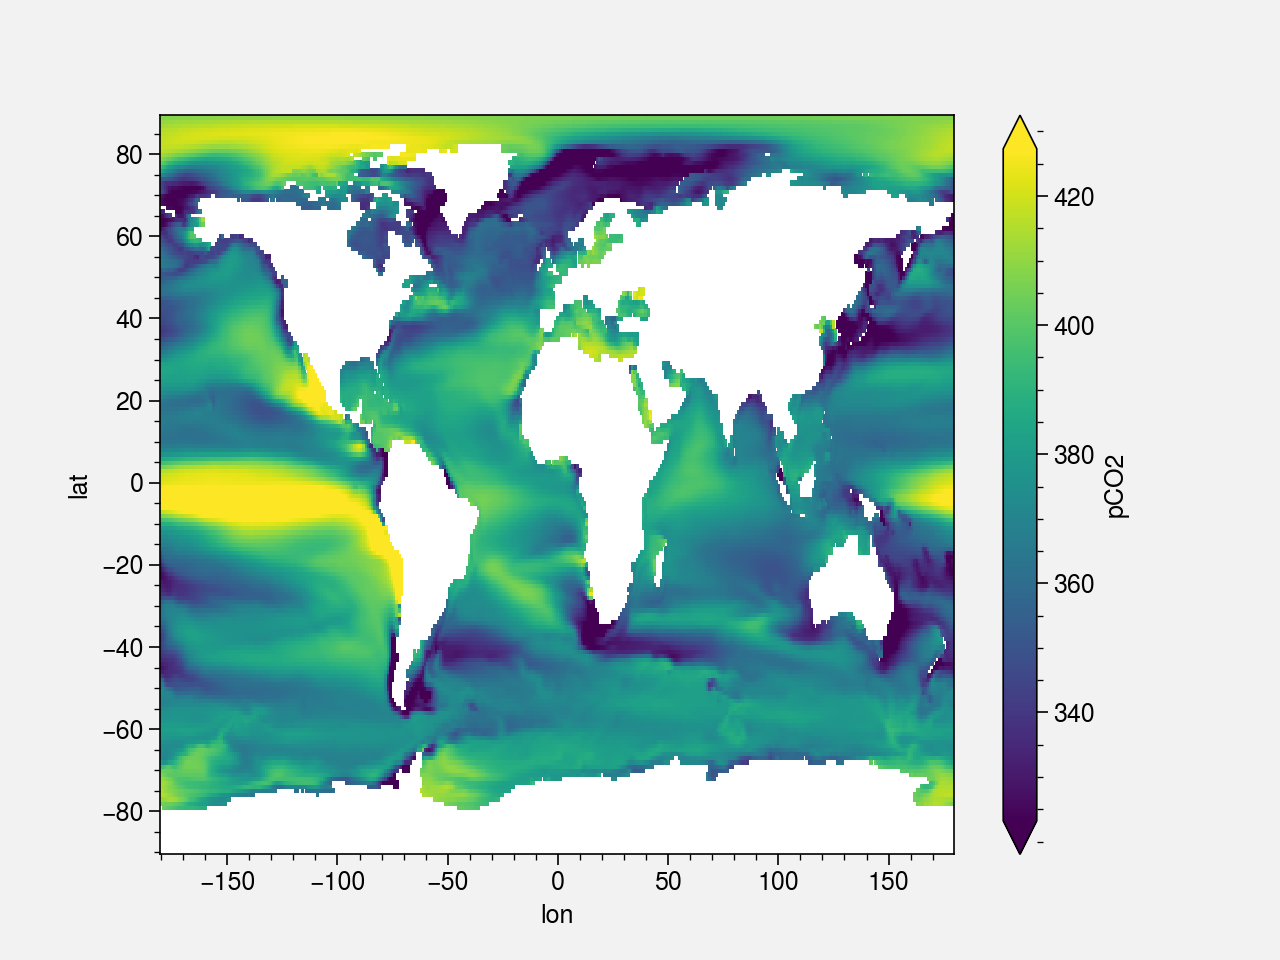

In [18]:
pCO2_darwin.mean('time').plot(robust=True)

/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


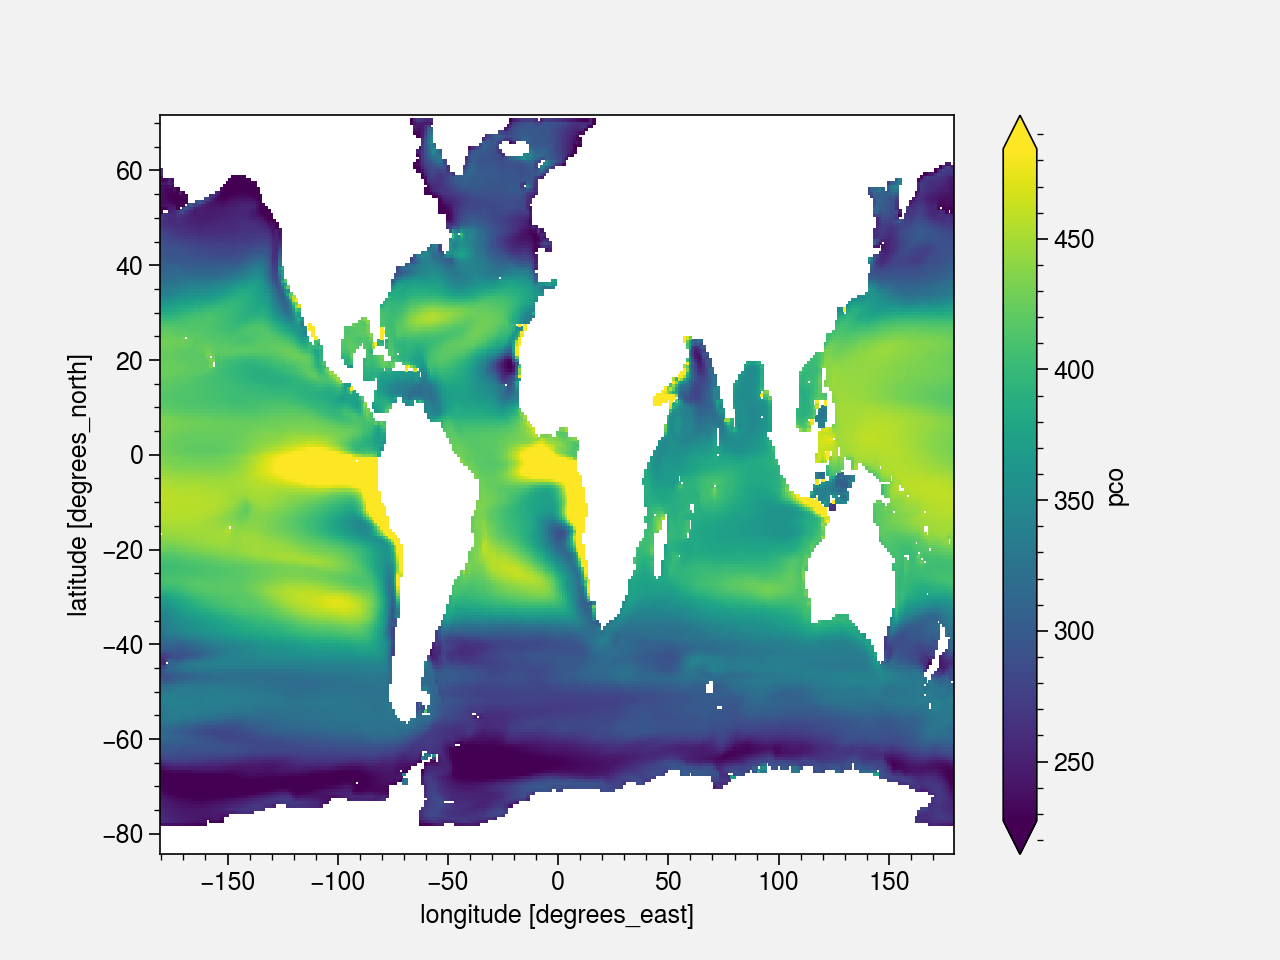

In [19]:
pCO2_nobm.mean('time').plot(robust=True)

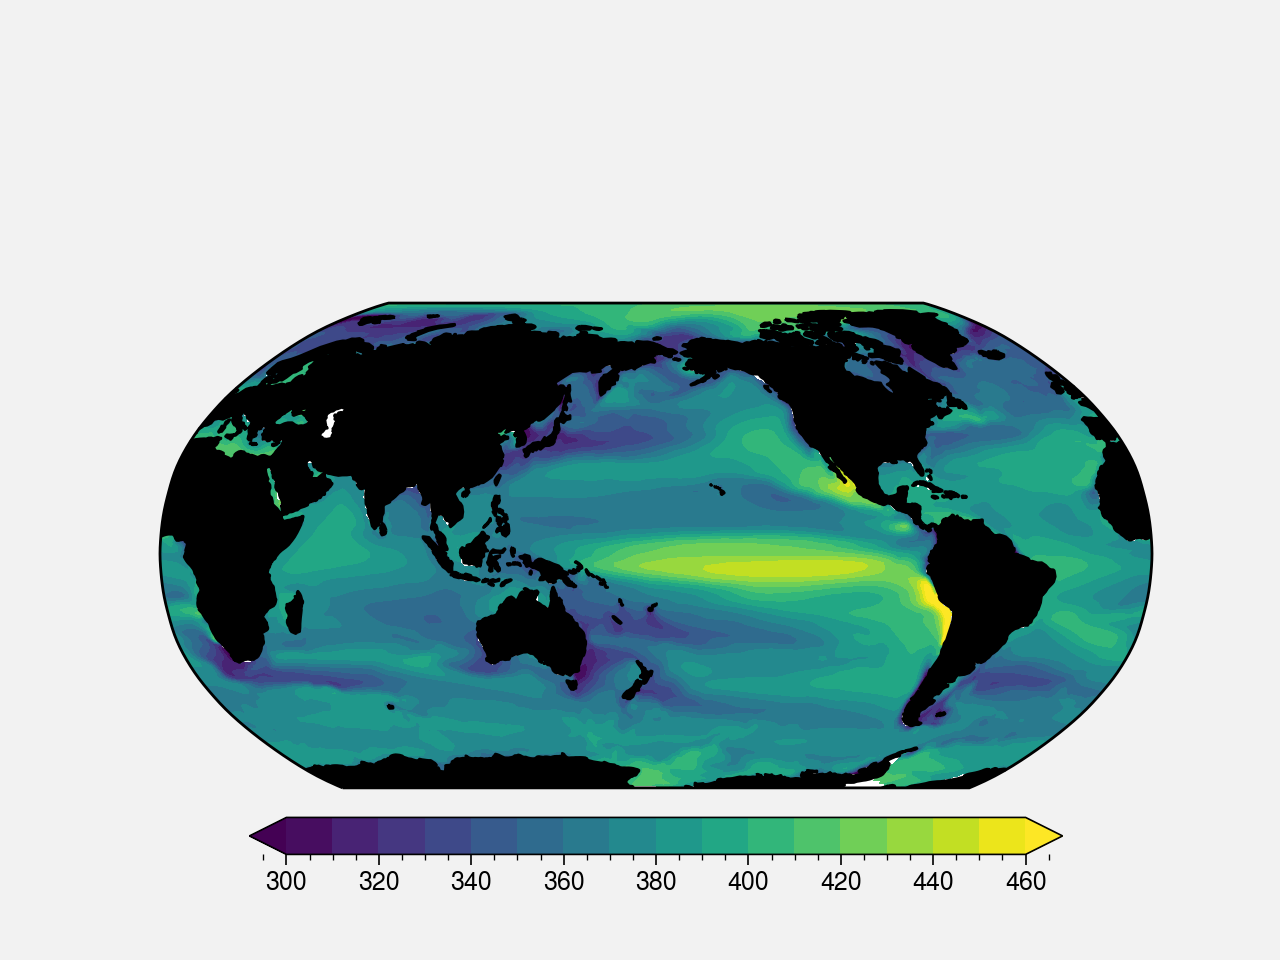

In [20]:
# Plot ECCODarwin pCO2 global map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

cyclic_data, cyclic_lon = add_cyclic_point(pCO2_darwin.mean('time'), coord=Cflux_darwin.lon.values)

p = ax.contourf(cyclic_lon, pCO2_darwin.lat, cyclic_data,
                levels=np.arange(300, 470, 10),
                transform=ccrs.PlateCarree(),
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

plt.savefig('2024_bgc/F1_ECCODarwin_pCO2_1998_2022_global.pdf', transparent=True, dpi=600)

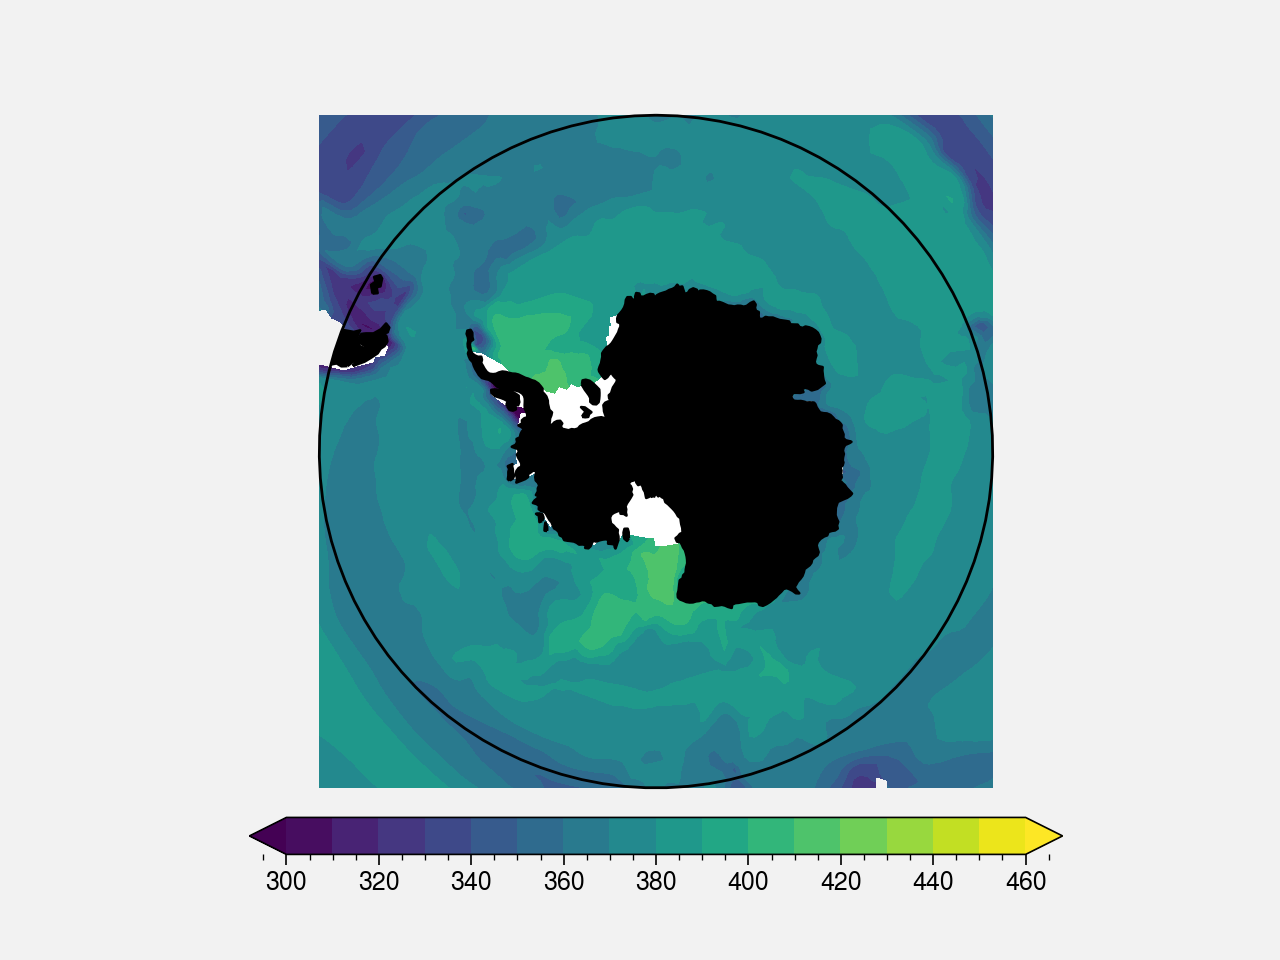

In [21]:
# Plot ECCODarwin pCO2 south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(pCO2_darwin.mean('time'), pCO2_darwin.lon.values)

p = ax.contourf(cyclic_lon, pCO2_darwin.lat, cyclic_data,
                levels=np.arange(300, 470, 10),
                transform=ccrs.PlateCarree(), 
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_ECCODarwin_pCO2_1998_2022_south_stereo.pdf', transparent=True, dpi=600)

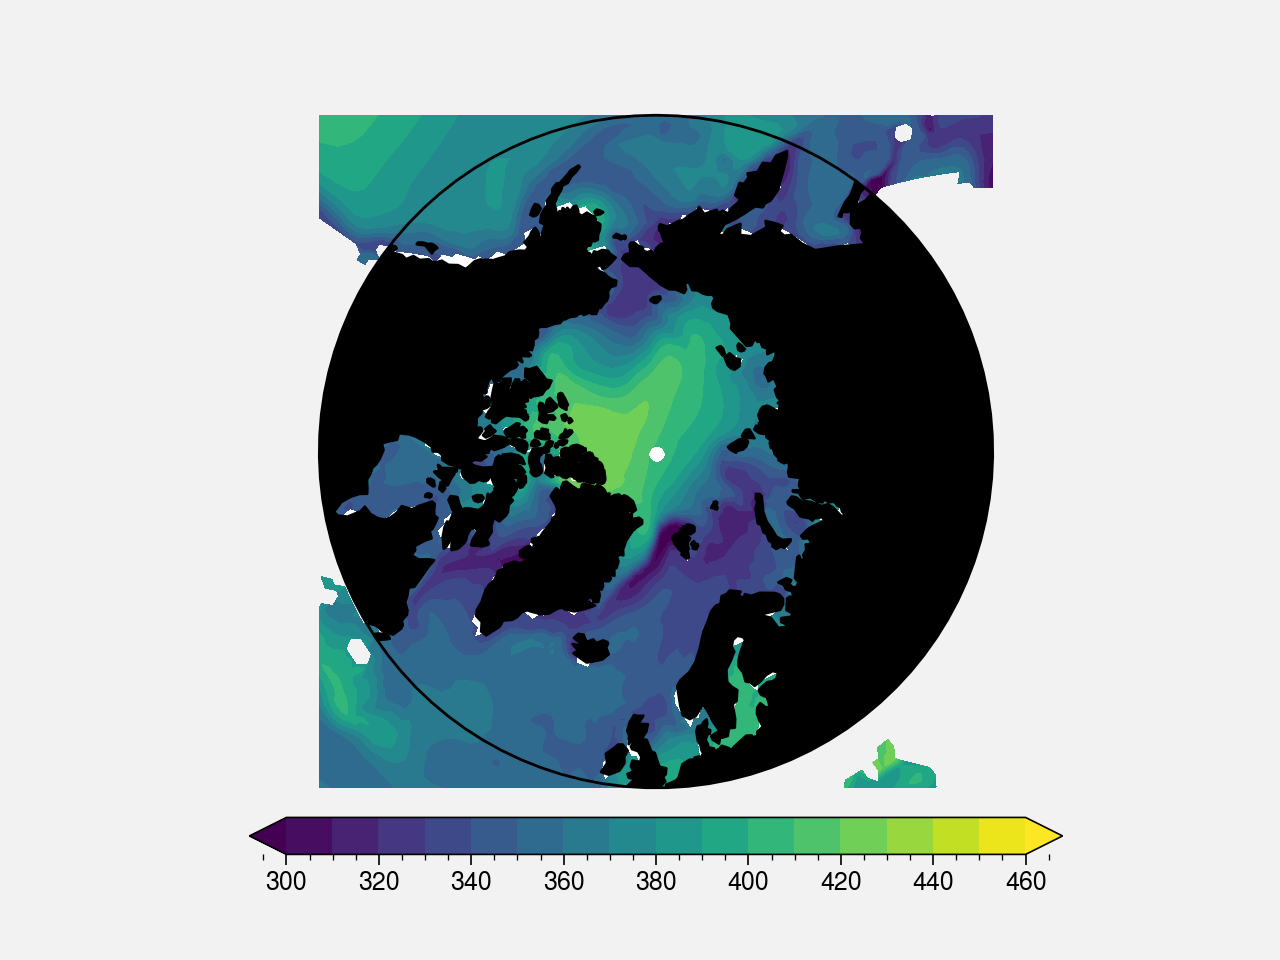

In [22]:
# Plot ECCODarwin pCO2 south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(pCO2_darwin.mean('time'), pCO2_darwin.lon.values)

p = ax.contourf(cyclic_lon, pCO2_darwin.lat, cyclic_data,
                levels=np.arange(300, 470, 10),
                transform=ccrs.PlateCarree(), 
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_ECCODarwin_pCO2_1998_2022_north_stereo.pdf', transparent=True, dpi=600)

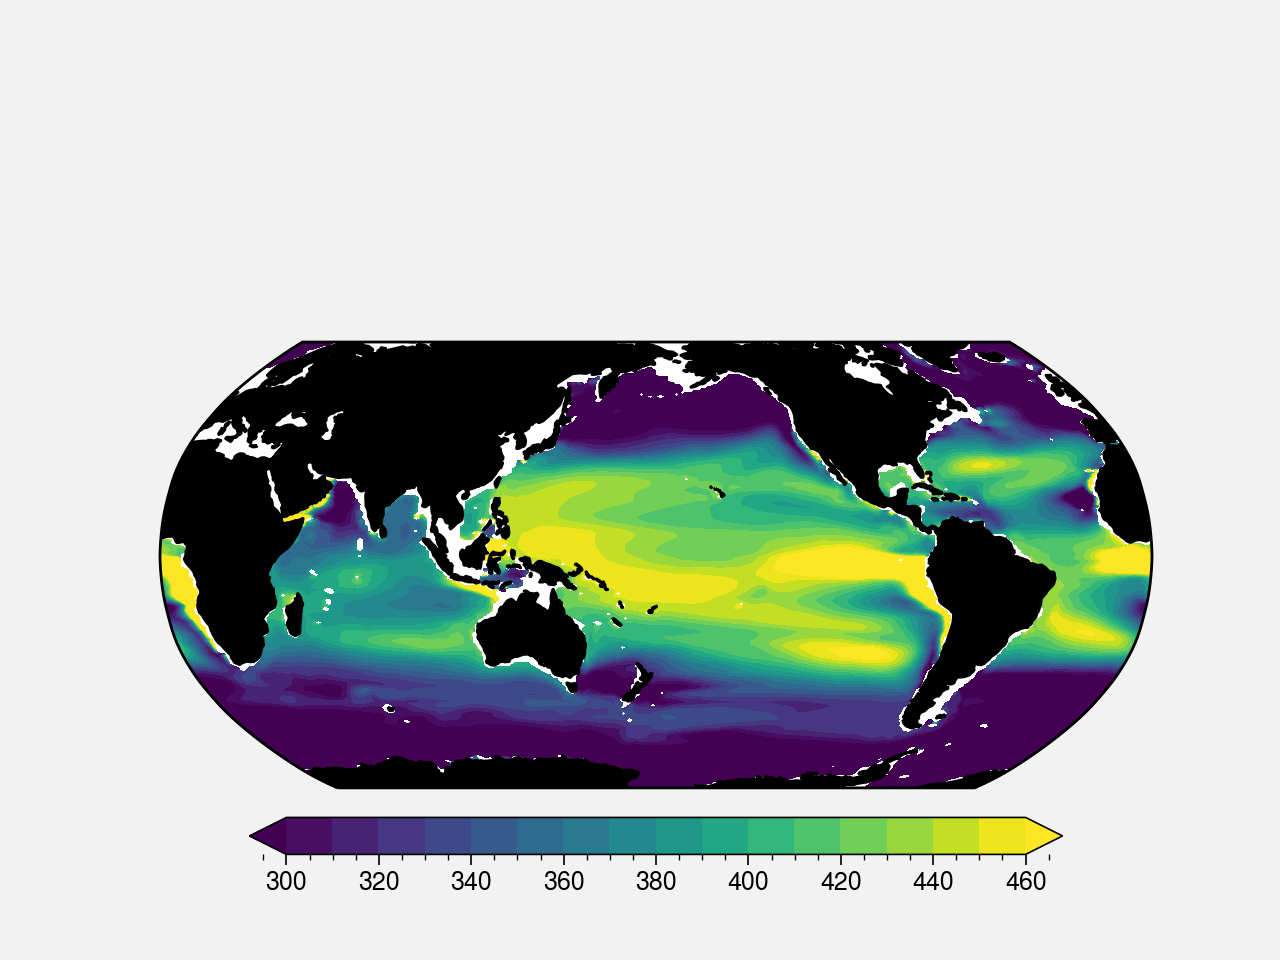

In [23]:
# Plot PoseidonNOBM pCO2 global map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

cyclic_data, cyclic_lon = add_cyclic_point(pCO2_nobm.mean('time'), coord=pCO2_nobm.lon.values)

p = ax.contourf(cyclic_lon, pCO2_nobm.lat, cyclic_data,
                levels=np.arange(300, 470, 10),
                transform=ccrs.PlateCarree(),
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

plt.savefig('2024_bgc/F1_PoseidonNOBM_pCO2_1998_2022_global.pdf', transparent=True, dpi=600)

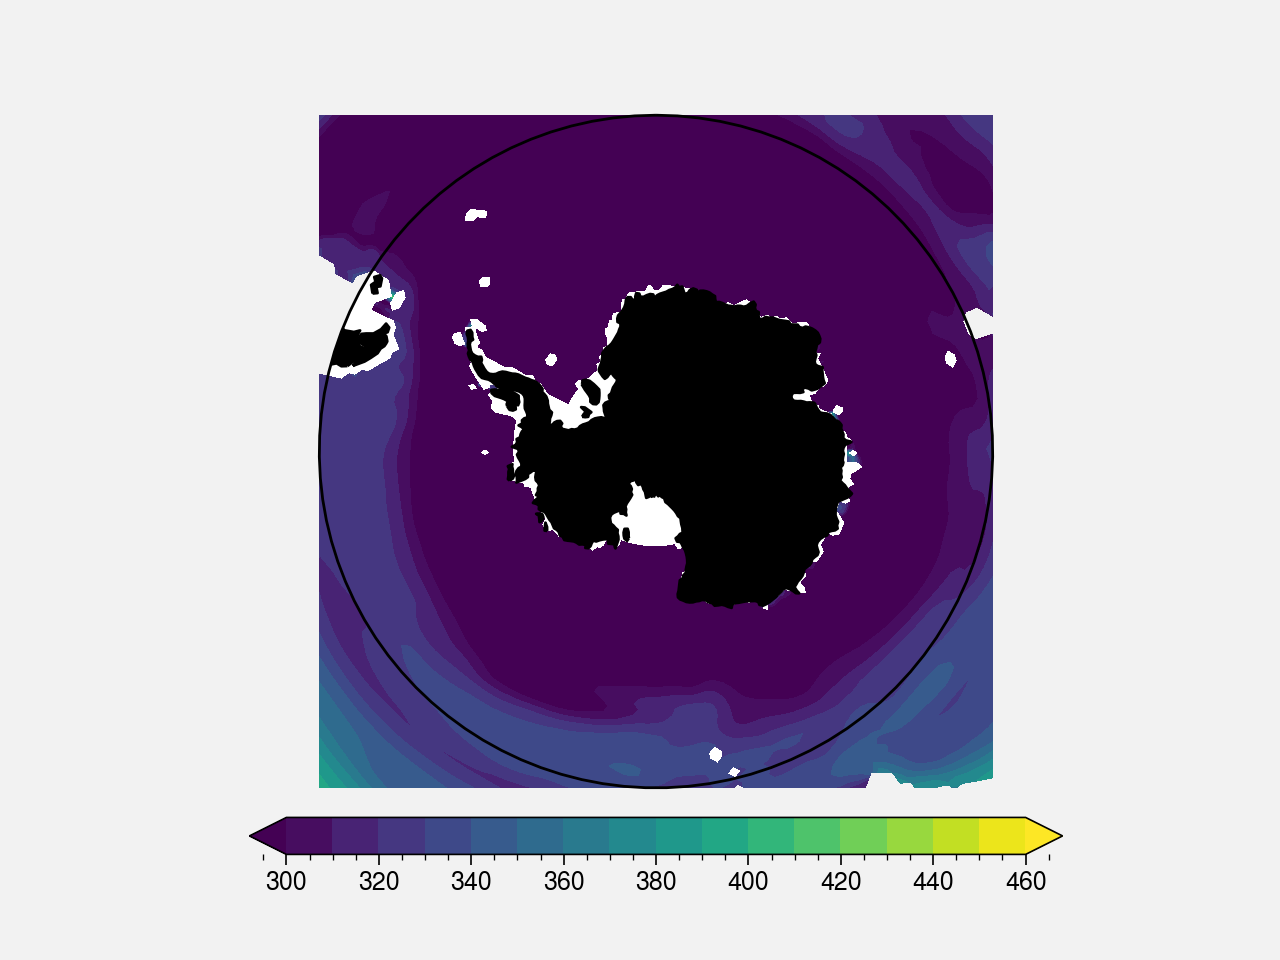

In [24]:
# Plot PoseidonNOBM pCO2 south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(pCO2_nobm.mean('time'), pCO2_nobm.lon.values)

p = ax.contourf(cyclic_lon, pCO2_nobm.lat, cyclic_data,
                levels=np.arange(300, 470, 10),
                transform=ccrs.PlateCarree(), 
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_PoseidonNOBM_pCO2_1998_2022_south_stereo.pdf', transparent=True, dpi=600)

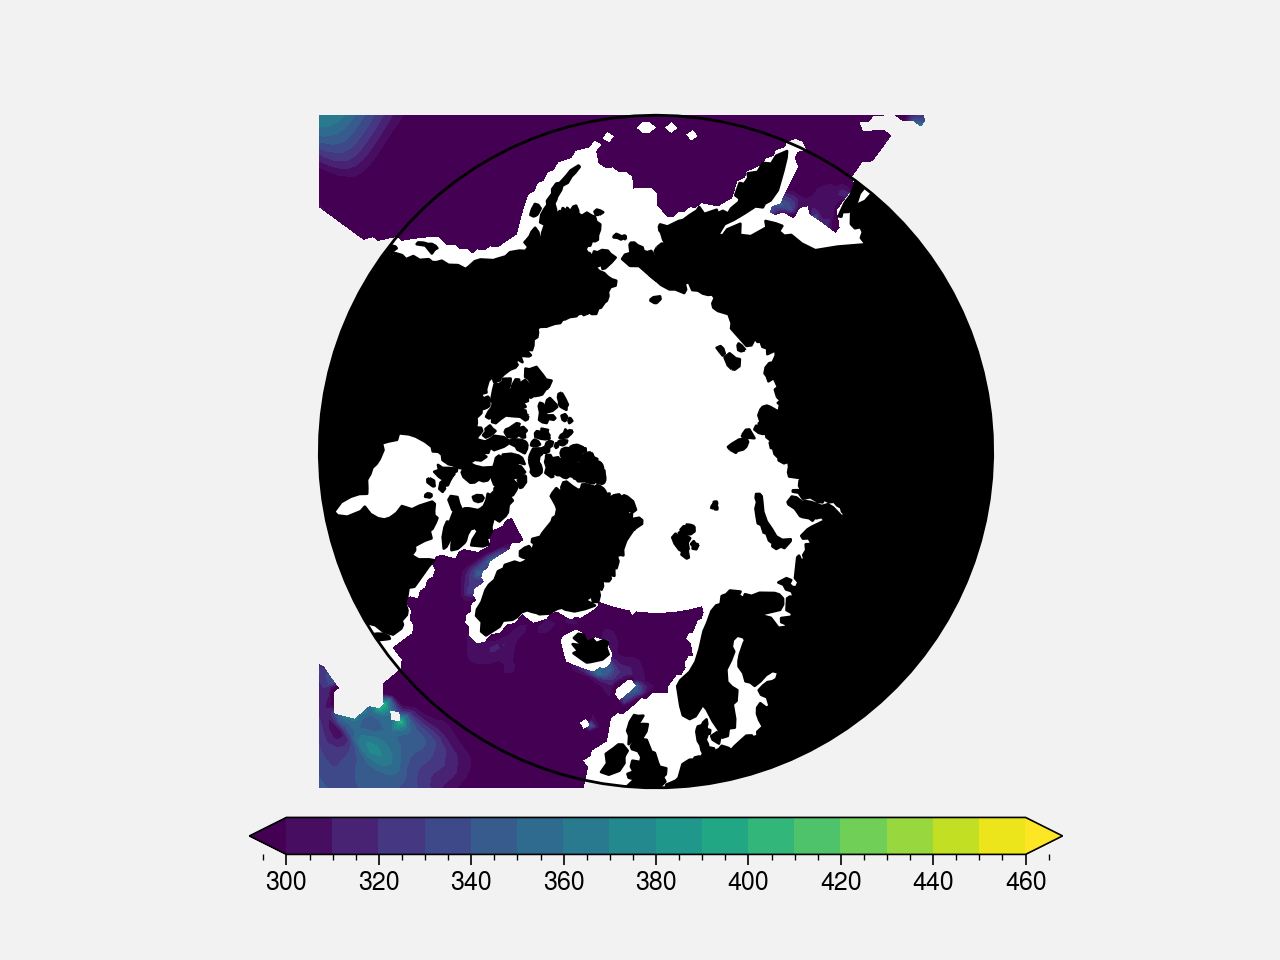

In [25]:
# Plot PoseidonNOBM pCO2 south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(pCO2_nobm.mean('time'), pCO2_nobm.lon.values)

p = ax.contourf(cyclic_lon, pCO2_nobm.lat, cyclic_data,
                levels=np.arange(300, 470, 10),
                transform=ccrs.PlateCarree(), 
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_PoseidonNOBM_pCO2_1998_2022_north_stereo.pdf', transparent=True, dpi=600)

### Plot maps of average C flux from 1998 to 2022

/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


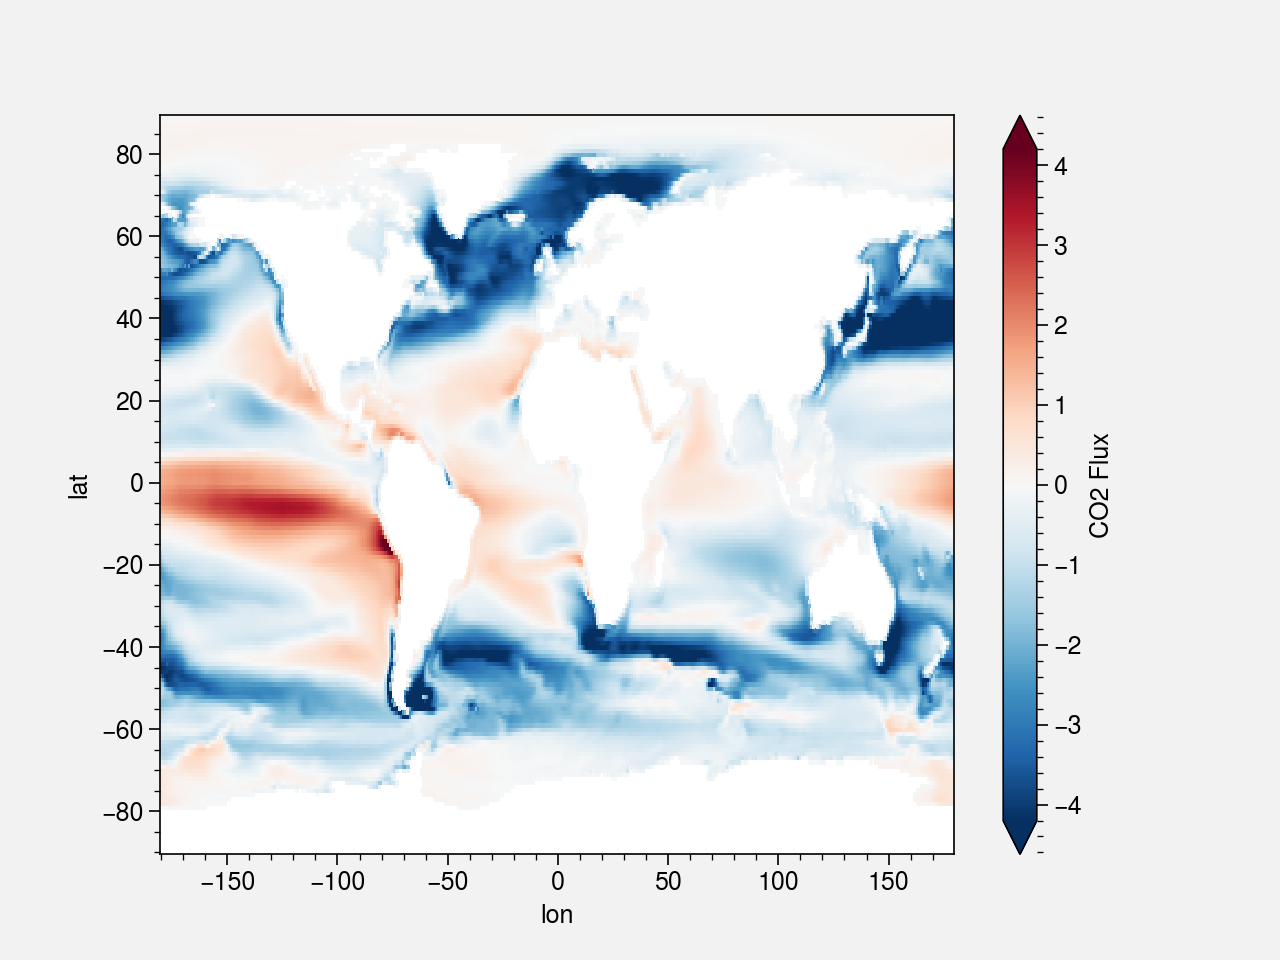

In [26]:
Cflux_darwin.mean('time').plot(robust=True)

/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


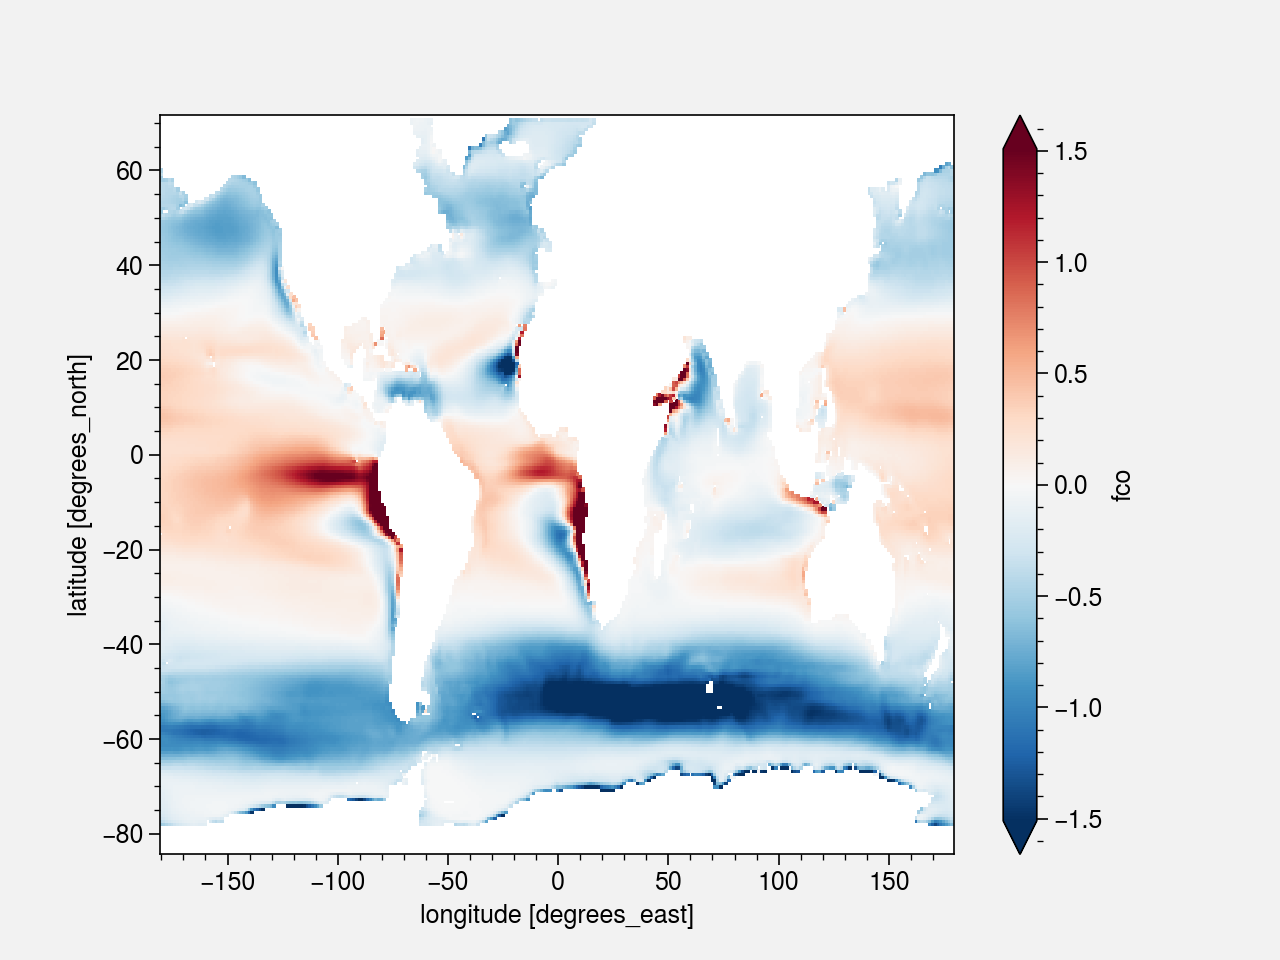

In [27]:
Cflux_nobm.mean('time').plot(robust=True)

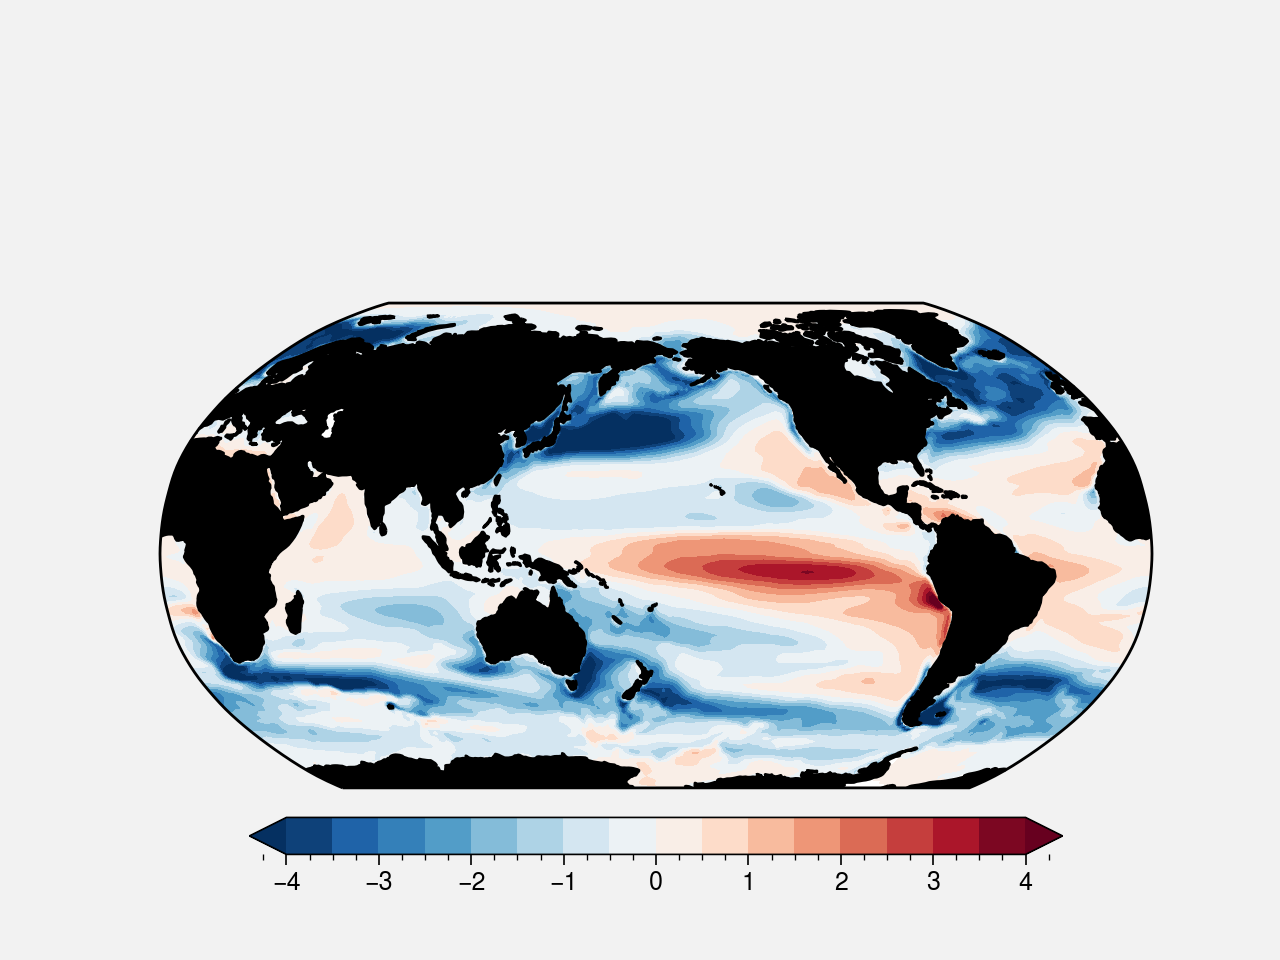

In [28]:
# Plot ECCODarwin Cflux global map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

cyclic_data, cyclic_lon = add_cyclic_point(Cflux_darwin.mean('time'), coord=Cflux_darwin.lon.values)

p = ax.contourf(cyclic_lon, Cflux_darwin.lat, cyclic_data,
                levels=np.arange(-4, 4.5, 0.5),
                transform=ccrs.PlateCarree(), 
                cmap='RdBu_r', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

plt.savefig('2024_bgc/F1_ECCODarwin_Cflux_1994_2022_global.pdf', transparent=True, dpi=600)

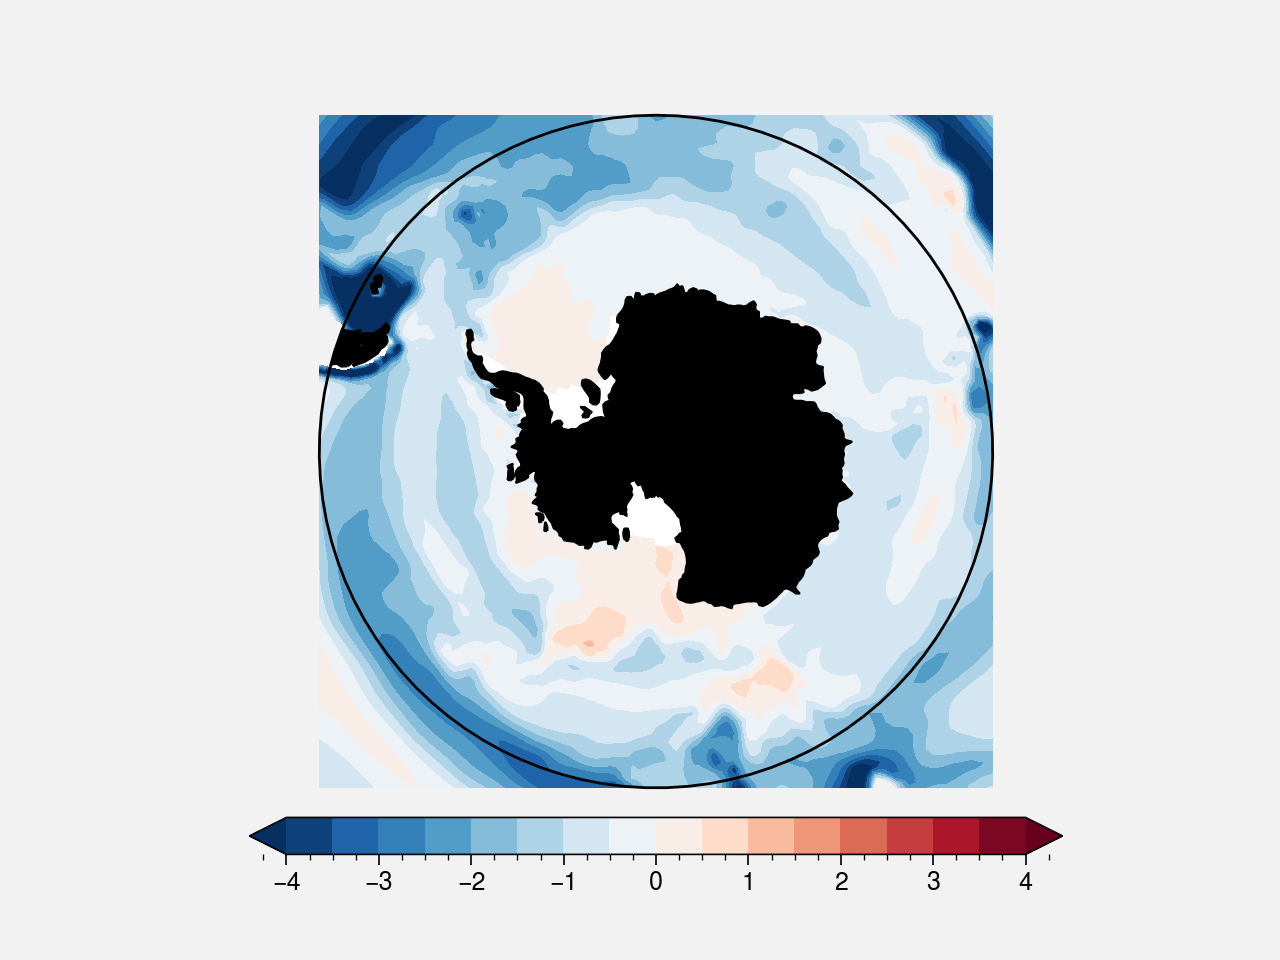

In [29]:
# Plot ECCODarwin Cflux south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(Cflux_darwin.mean('time'), Cflux_darwin.lon.values)

p = ax.contourf(cyclic_lon, Cflux_darwin.lat, cyclic_data,
                levels=np.arange(-4, 4.5, 0.5),
                transform=ccrs.PlateCarree(), 
                cmap='RdBu_r', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_ECCODarwin_Cflux_1994_2022_south_stereo.pdf', transparent=True, dpi=600)

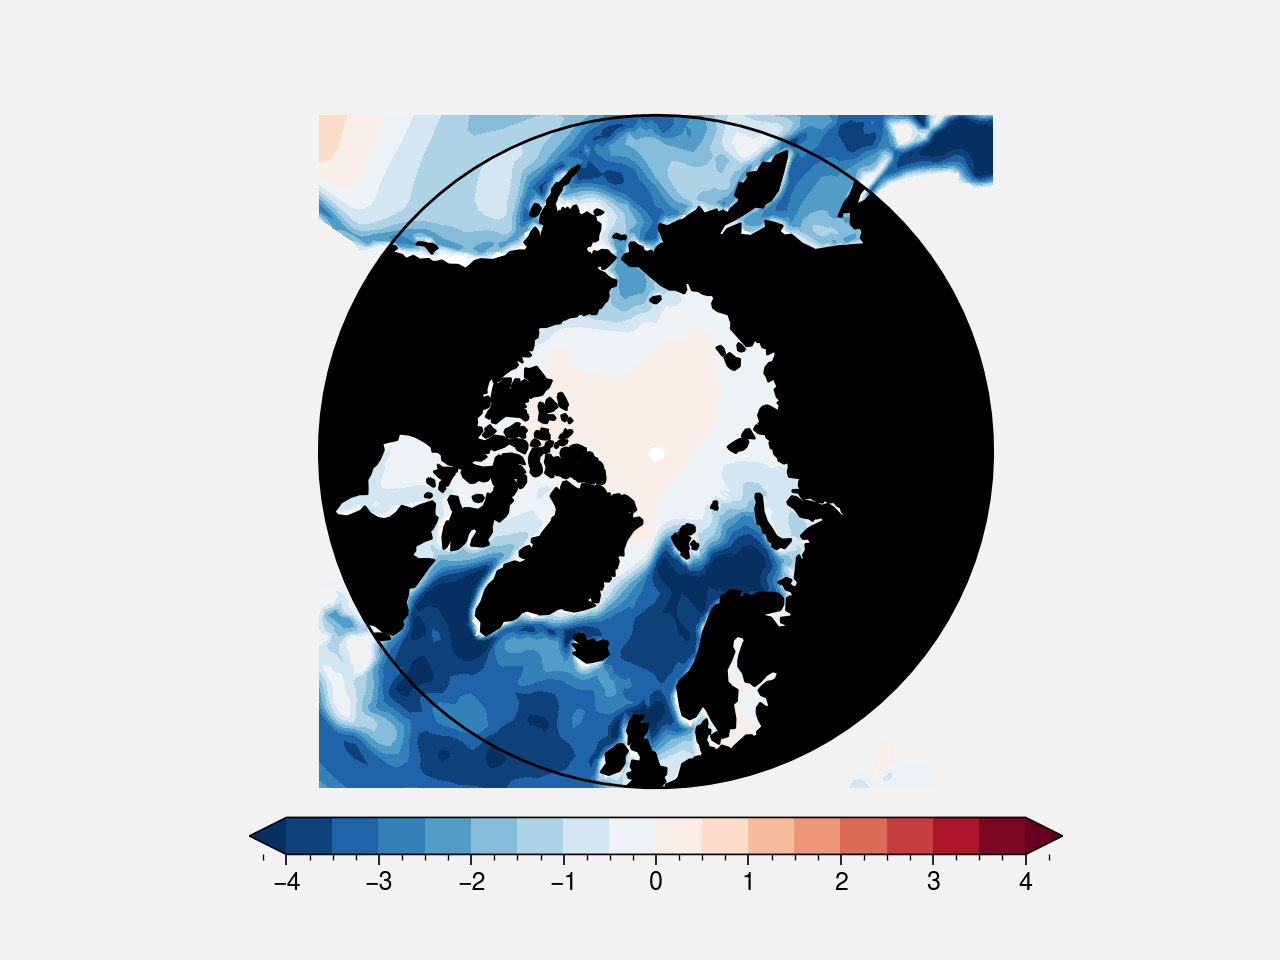

In [30]:
# Plot ECCODarwin Cflux south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(Cflux_darwin.mean('time'), Cflux_darwin.lon.values)

p = ax.contourf(cyclic_lon, Cflux_darwin.lat, cyclic_data,
                levels=np.arange(-4, 4.5, 0.5),
                transform=ccrs.PlateCarree(), 
                cmap='RdBu_r', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_ECCODarwin_Cflux_1994_2022_north_stereo.pdf', transparent=True, dpi=600)

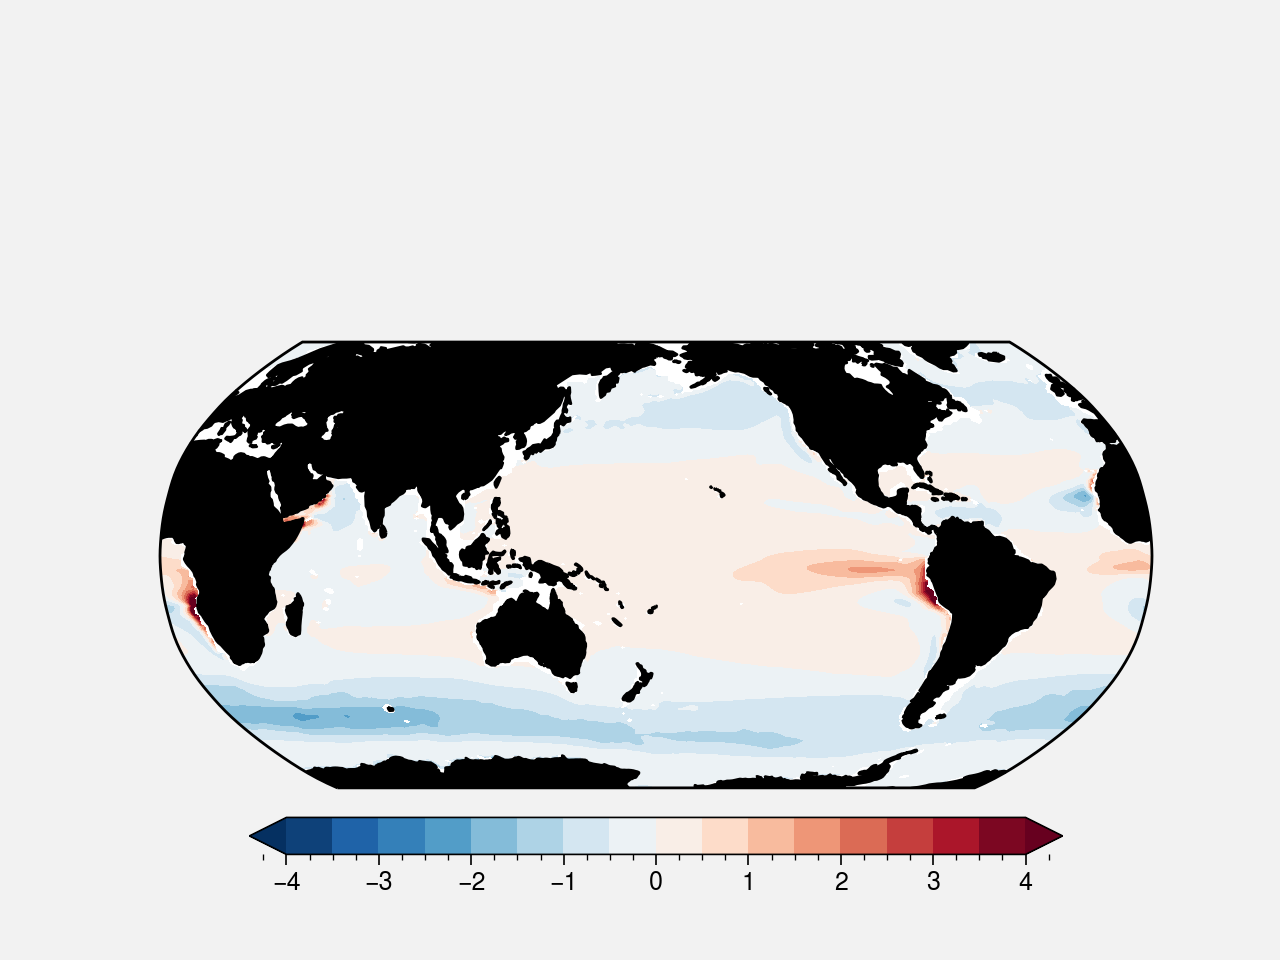

In [31]:
# Plot PoseidonNOBM Cflux global map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

cyclic_data, cyclic_lon = add_cyclic_point(Cflux_nobm.mean('time'), coord=Cflux_nobm.lon.values)

p = ax.contourf(cyclic_lon, Cflux_nobm.lat, cyclic_data,
                levels=np.arange(-4, 4.5, 0.5),
                transform=ccrs.PlateCarree(), 
                cmap='RdBu_r', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

plt.savefig('2024_bgc/F1_PoseidonNOBM_Cflux_1994_2022_global.pdf', transparent=True, dpi=600)

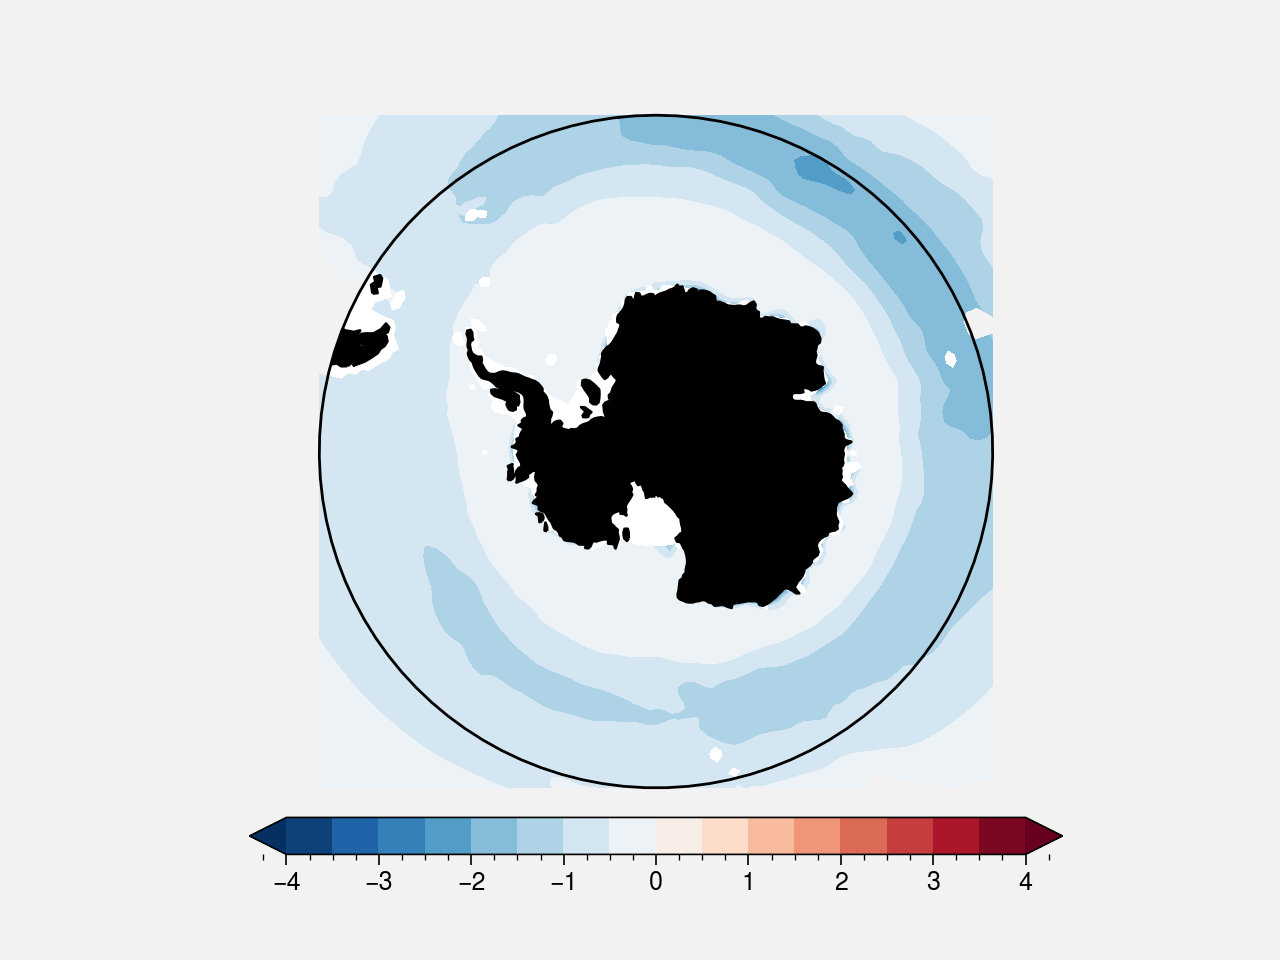

In [32]:
# Plot PoseidonNOBM Cflux south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(Cflux_nobm.mean('time'), Cflux_nobm.lon.values)

p = ax.contourf(cyclic_lon, Cflux_nobm.lat, cyclic_data,
                levels=np.arange(-4, 4.5, 0.5),
                transform=ccrs.PlateCarree(), 
                cmap='RdBu_r', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_PoseidonNOBM_Cflux_1994_2022_south_stereo.pdf', transparent=True, dpi=600)

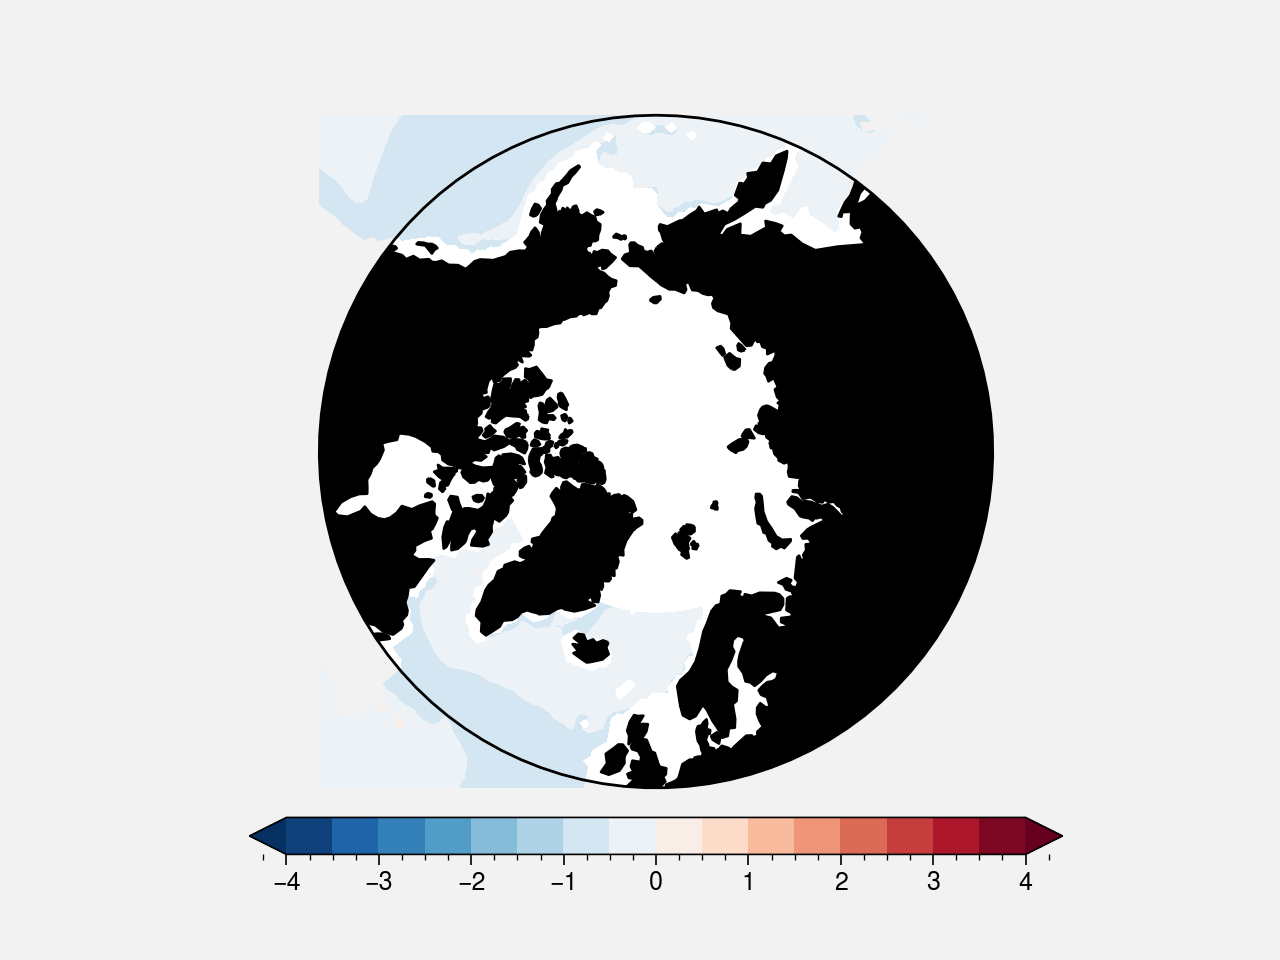

In [33]:
# Plot PoseidonNOBM Cflux south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(Cflux_nobm.mean('time'), Cflux_nobm.lon.values)

p = ax.contourf(cyclic_lon, Cflux_nobm.lat, cyclic_data,
                levels=np.arange(-4, 4.5, 0.5),
                transform=ccrs.PlateCarree(), 
                cmap='RdBu_r', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('2024_bgc/F1_PoseidonNOBM_Cflux_1994_2022_north_stereo.pdf', transparent=True, dpi=600)

### Mask datasets using Tagliabue mask and plot timeseries

In [34]:
# Apply Tagliabue mask 
# mask = xr.open_dataset('/glade/u/home/elsworth/masks/Tagliabue_regions_mask.nc')
# Apply Fay and McKinley 2014 biome mask
mask = xr.open_dataset('/glade/u/home/elsworth/masks/Time_Varying_Biomes.nc')
mask

<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360, year: 13)
Coordinates:
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year               (year) float64 1.998e+03 1.999e+03 ... 2.009e+03 2.01e+03
Data variables:
    MeanBiomes         (lon, lat) float64 ...
    CoreBiomes         (lon, lat) float64 ...
    TimeVaryingBiomes  (lon, lat, year) float64 ...
Attributes:
    Title:        Global Biomes
    Description:  Global Mean, Core, and Time-varying Biomes for years 1998-2010
    Authors:      AR Fay and GA McKinley University of Wisconsin
    Date:         June 2014
    Notes:        Biomes as described in Fay & McKinley, (2014) Global open o...

In [35]:
# # Tagliabue
# mask = mask.swap_dims({'LATITUDE':'lat','LONGITUDE':'lon'})
# mask

In [36]:
# # Tagliabue
# mask['lon'] = np.arange(0,360,1)
# mask['lat'] = np.arange(-89.5,90.5,1)
# mask

In [37]:
# # Tagliabue
# mask = mask.drop('LONGITUDE')
# mask = mask.drop('LATITUDE')
# mask

/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


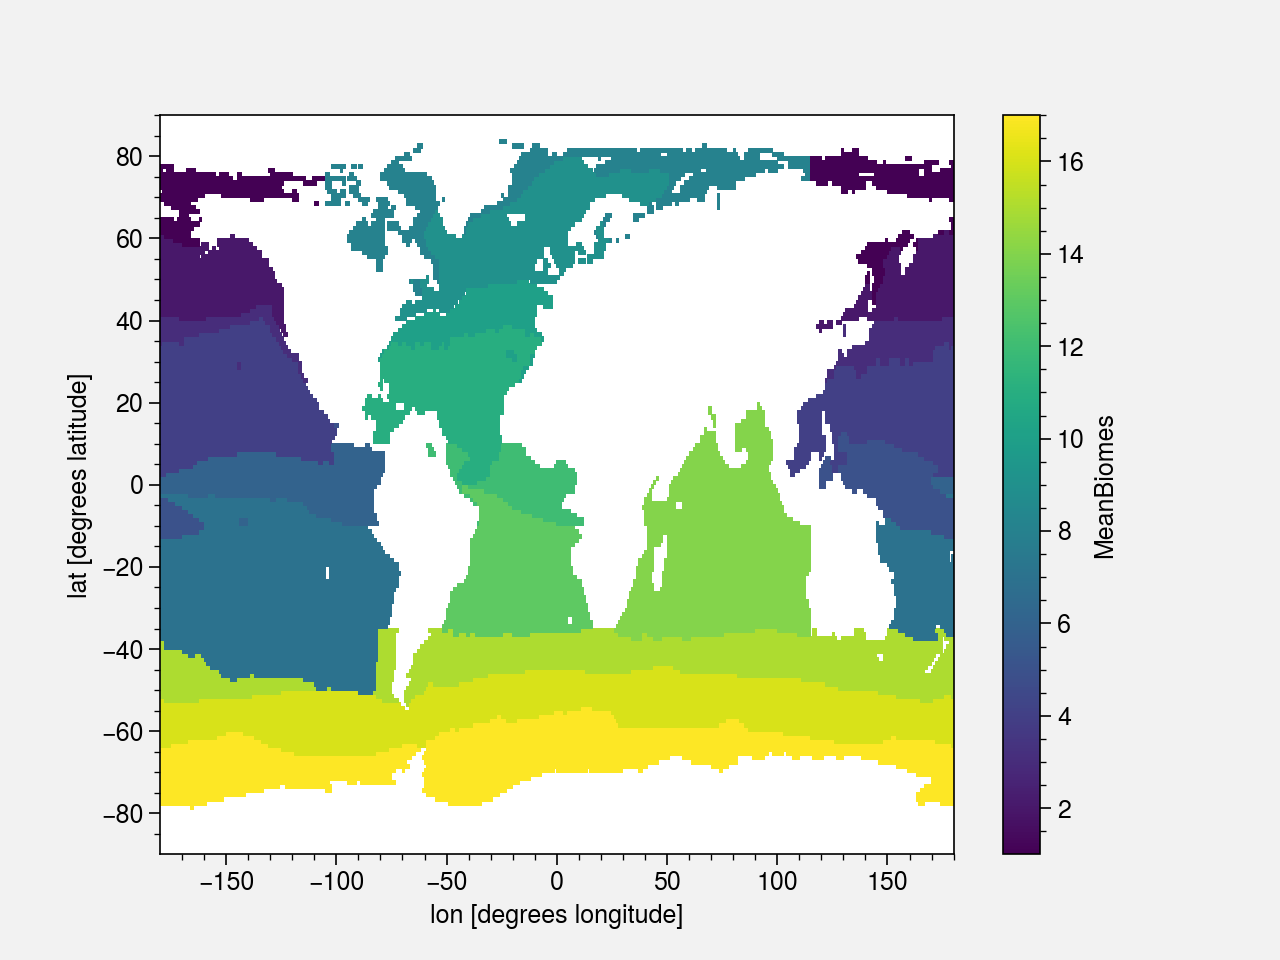

In [38]:
# Fay
# Flip dimensions 
mask = mask.transpose('lat','lon','year')
mask.MeanBiomes.plot()

In [40]:
Mask = mask.MeanBiomes

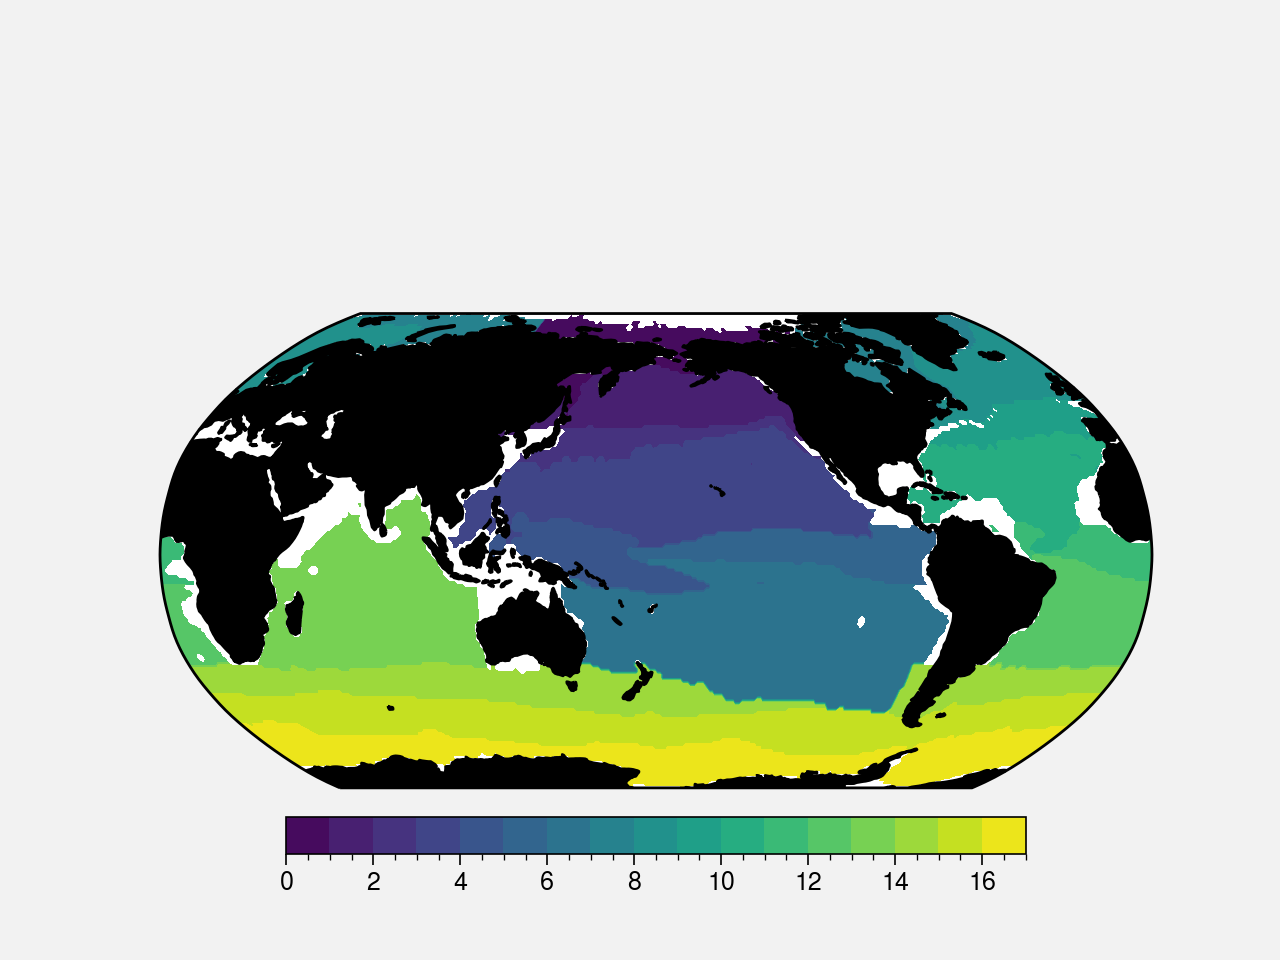

In [41]:
# Plot ECCODarwin pCO2 global map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

cyclic_data, cyclic_lon = add_cyclic_point(Mask, coord=Mask.lon.values)

p = ax.contourf(cyclic_lon, Mask.lat, cyclic_data,
                levels=np.arange(0, 18, 1),
                transform=ccrs.PlateCarree(),
                cmap='viridis', extend='neither')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, label='', ticks=None)

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

plt.savefig('fay_mckinley_2014.pdf', transparent=True, dpi=600)

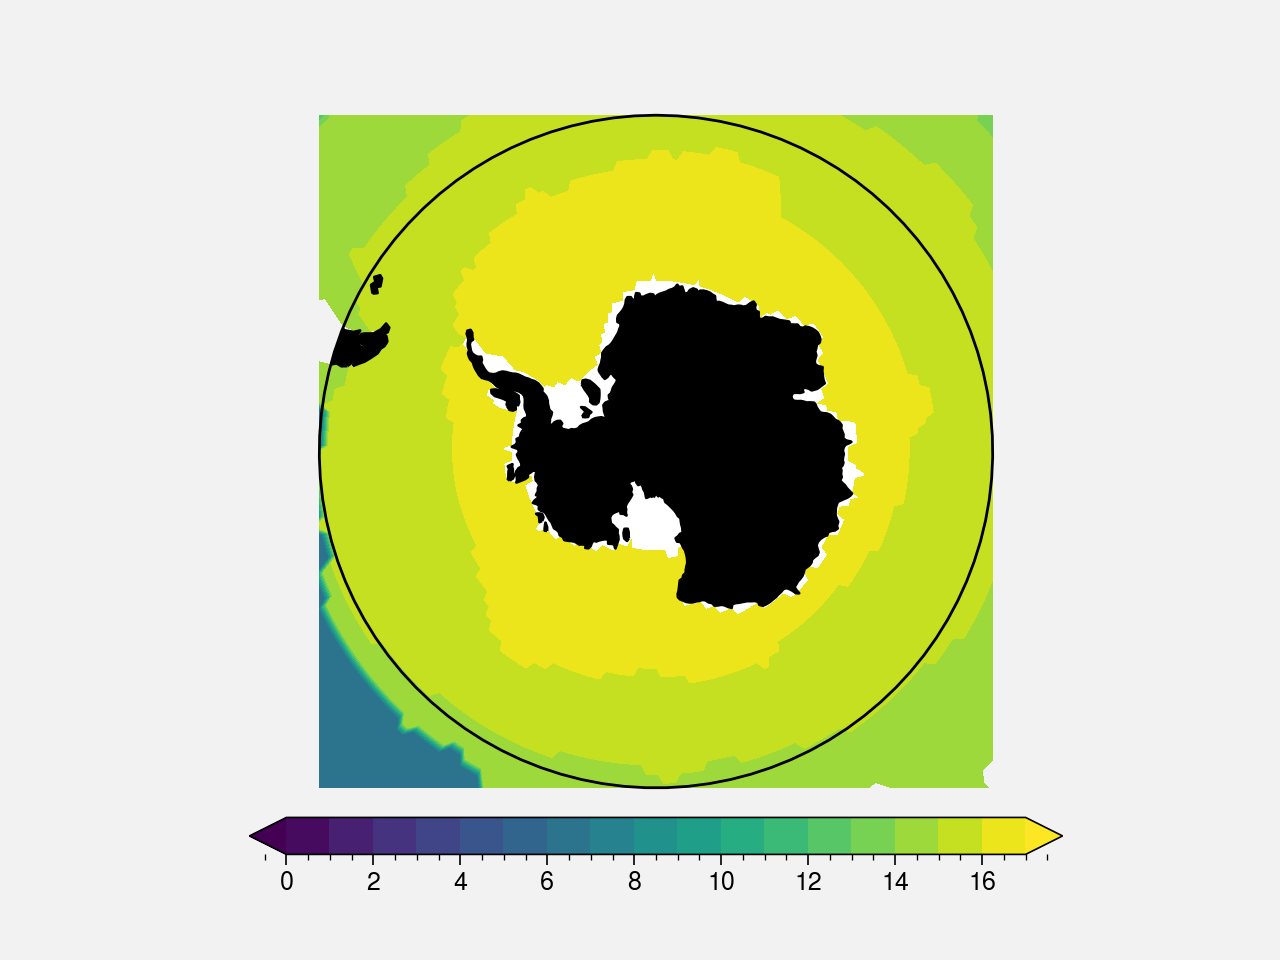

In [42]:
# Plot ECCODarwin pCO2 south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(Mask, Mask.lon.values)

p = ax.contourf(cyclic_lon, Mask.lat, cyclic_data,
                levels=np.arange(0, 18, 1),
                transform=ccrs.PlateCarree(), 
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('Fay_McKinley_2014_south_stereo.pdf', transparent=True, dpi=600)

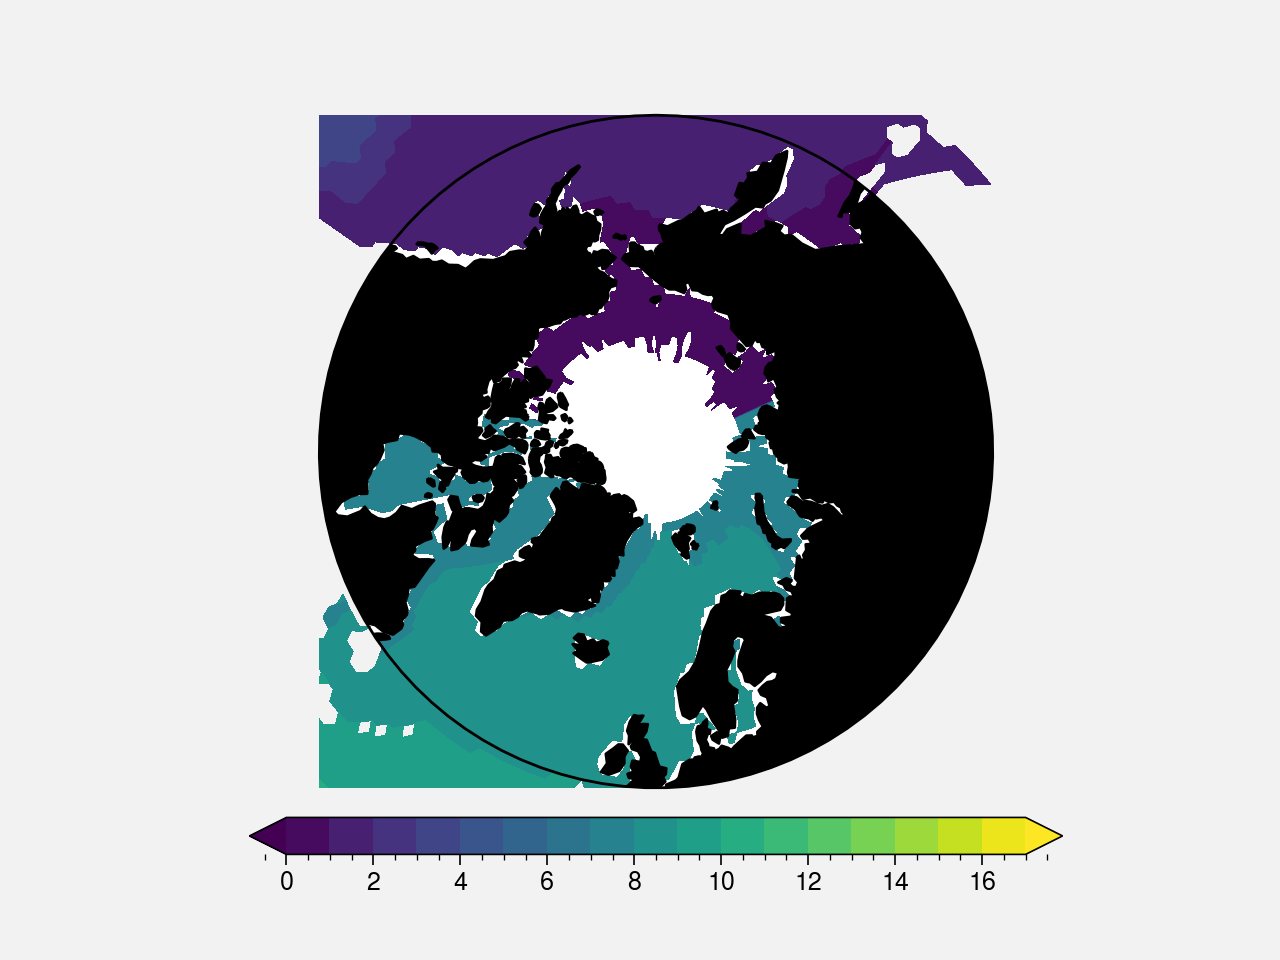

In [43]:
# Plot ECCODarwin pCO2 south stereo map
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=0)))

cyclic_data, cyclic_lon = add_cyclic_point(Mask, pCO2_darwin.lon.values)

p = ax.contourf(cyclic_lon, Mask.lat, cyclic_data,
                levels=np.arange(0, 18, 1),
                transform=ccrs.PlateCarree(), 
                cmap='viridis', extend='both')

plt.colorbar(p, orientation='horizontal', fraction=0.05, pad=0.04, 
             label='')

ax.coastlines(resolution='110m', color='black', linewidth=1)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))

ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('Fay_McKinley_2014_north_stereo.pdf', transparent=True, dpi=600)

In [44]:
pCO2_darwin['lon'] = np.arange(-179.5,180.5,1)
pCO2_darwin['lat'] = np.arange(-89.5,90.5,1)

In [45]:
darwin_mask = pCO2_darwin.where(Mask==8)

/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/glade/u/home/elsworth/.conda/envs/analysis-2/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


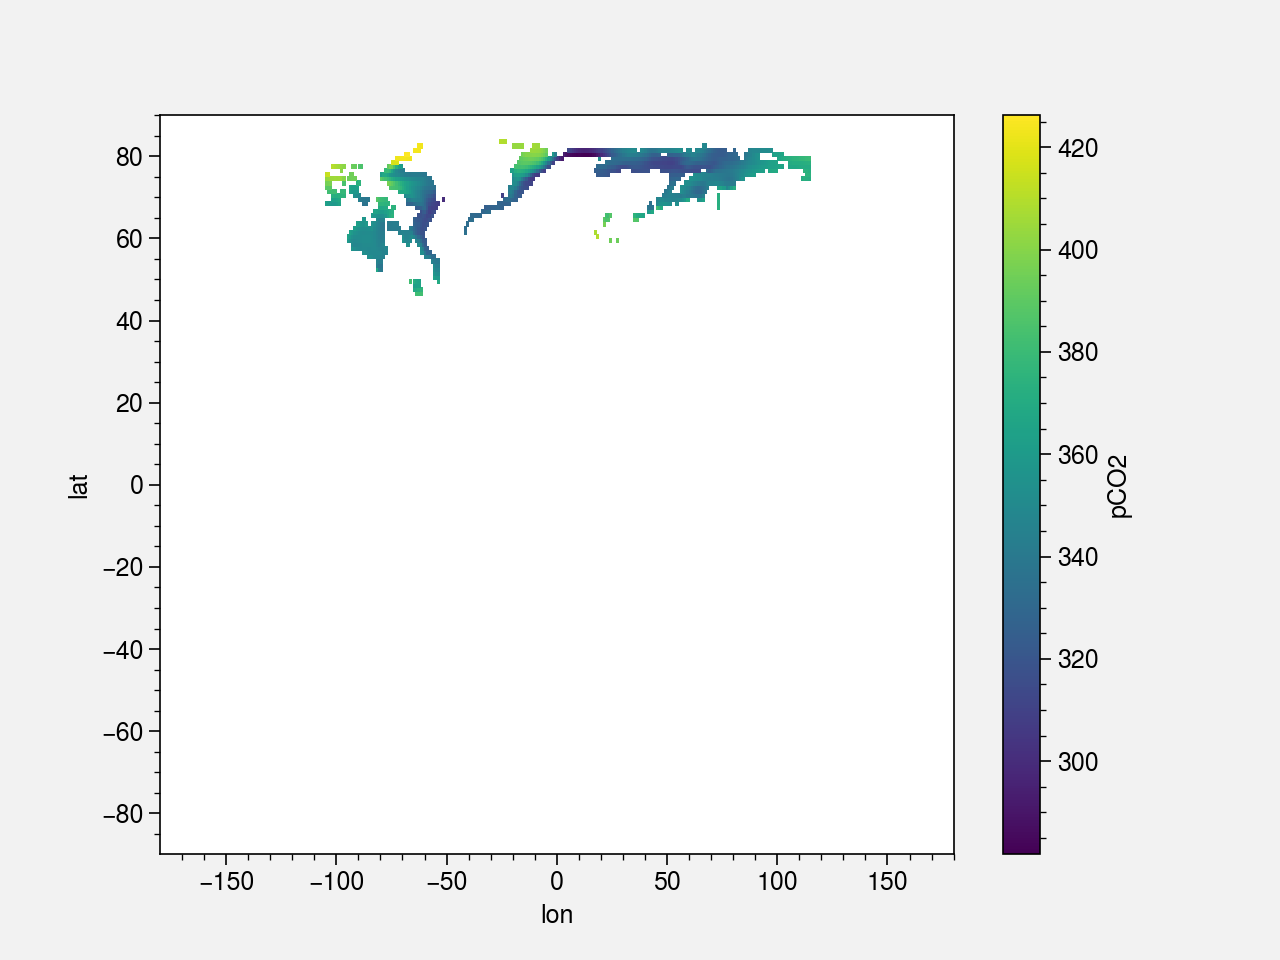

In [46]:
darwin_mask.mean('time').plot()

In [ ]:
# # Mask a specific region
# Mask = mask.ARC
# Mask.plot()

In [ ]:
# Cflux_darwin

In [ ]:
# # Change lat and lon coords so they're the same as the mask
# Cflux_darwin['lat'] = np.arange(-89.5,90.5,1)
# Cflux_darwin['lon'] = np.arange(0,360,1)

In [ ]:
# # Mask ECCODarwin dataset
# darwin_mask = Cflux_darwin.where(Mask == 1)
# darwin_mask.mean('time').plot()

In [ ]:
# darwin_mask.mean(['lat','lon']).plot()
# areawt_darwin_ds.plot()

In [ ]:
# # Determine area weights
# weights = np.cos(np.deg2rad(pCO2_darwin.lat))
# weights.name = "weights"
# # Weight by area
# areawt_darwin_ds = pCO2_darwin.weighted(weights)
# # Sum mmol C / yr
# areawt_darwin_ds = areawt_darwin_ds.mean(('lon','lat'))

In [47]:
darwin_mask = pCO2_darwin.where(Mask==17)

In [48]:
# Determine area weights
weights = np.cos(np.deg2rad(darwin_mask.lat))
weights.name = "weights"
# Weight by area
areawt_darwin_ds = darwin_mask.weighted(weights)
# Sum mmol C / yr
areawt_darwin_ds = areawt_darwin_ds.mean(('lon','lat'))

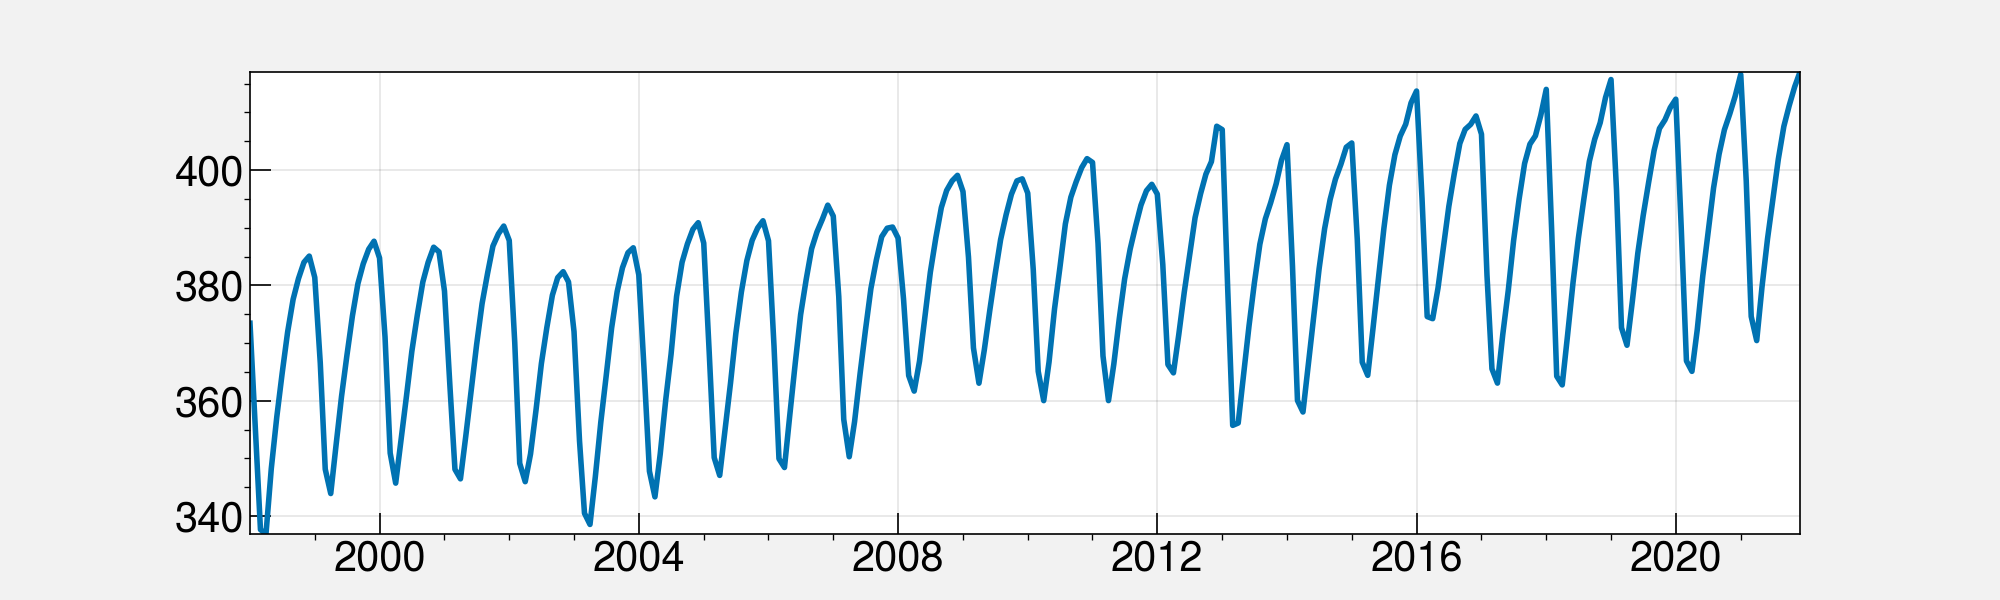

In [49]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)

ax.plot(areawt_darwin_ds.time, areawt_darwin_ds, linewidth=2)
# ax.plot(diatC_zint.time, diatC_zint.mean(['member_id']), linewidth=2, color='black')

# ax.set_ylabel('pCO$_2$ (uatm)', fontsize = 15)
ax.grid(True)
# # ax.set_ylim([26.5, 36.5])
ax.set_xlim(['1998-01-01', '2021-12-01'])
ax.tick_params(labelsize=15, length=7.5, direction='in', tick1On=True, labelbottom=True)

plt.savefig('ECCODarwin_biome17_pCO2_1998_2022.pdf', transparent=True, dpi=600)